In [307]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [308]:
def load_results_dataframe(dir: Path, pattern: str) -> pd.DataFrame:
    """
    Walks dir for files named 'episodes_*.json', loads them,
    and returns a single DataFrame with columns:
      - all keys from your JSON records
      - 'source_file': the filename each record came from
      - 'modified_time': a pandas.Timestamp of the file's mtime
    
    Rows are sorted by modified_time (most recent first).
    """
    records = []
    
    # 1) list files oldest → newest
    files = sorted(
        dir.glob(pattern),
        key=lambda p: p.stat().st_mtime,
    )
    
    for file_idx, path in enumerate(files):
        mtime = pd.to_datetime(path.stat().st_mtime, unit="s")
        content = json.loads(path.read_text())
        
        if isinstance(content, list):
            for entry_idx, entry in enumerate(content):
                rec = dict(entry)
                rec.update({
                    "source_file":   path.name,
                    "modified_time": mtime,
                    "file_index":    file_idx,
                    "entry_index":   entry_idx,
                })
                records.append(rec)
        
        elif isinstance(content, dict):
            rec = dict(content)
            rec.update({
                "source_file":   path.name,
                "modified_time": mtime,
                "file_index":    file_idx,
                "entry_index":   0,
            })
            records.append(rec)
        
        else:
            # fallback for other JSON shapes
            records.append({
                "source_file":   path.name,
                "modified_time": mtime,
                "file_index":    file_idx,
                "entry_index":   0,
                "data":          content,
            })
    
    df = pd.DataFrame(records)
    # row‐order == episode‐order
    return df

def load_episodes_dataframe(dir: Path) -> pd.DataFrame:
    return load_results_dataframe(dir=dir, pattern="episodes_*.json")

In [ ]:
training_dir = Path("outputs/1753645791695407476")

In [310]:
training_params = json.load(open(training_dir / "training_params.json", "r"))
for k, v in training_params.items():
    print(f"{k}: {v}")

n_episodes: 100000000
pretrained_dir: None
opponent_pretrained_dir: None
seed: 42
epsilon_max: 1.0
epsilon_min: 0.1
epsilon_decay_rate: 0.99
opponent: RANDOM_AGENT
training: 2


In [311]:
episodes = load_episodes_dataframe(training_dir)
episodes.head()

,n_updates,mean_td_error,mean_abs_td_error,mean_squared_td_error,max_abs_td_error,final_reward,source_file,modified_time,file_index,entry_index
0,5,0.00,0.00,0.00,0.0,-0.0,episodes_0.json,2025-07-27 19:49:51.702422619,0,0
1,4,-0.25,0.25,0.25,1.0,-1.0,episodes_500000.json,2025-07-27 19:50:55.767575502,1,0
2,4,-0.25,0.25,0.25,1.0,-1.0,episodes_500000.json,2025-07-27 19:50:55.767575502,1,1
3,5,0.00,0.00,0.00,0.0,-0.0,episodes_500000.json,2025-07-27 19:50:55.767575502,1,2
4,4,-0.25,0.25,0.25,1.0,-1.0,episodes_500000.json,2025-07-27 19:50:55.767575502,1,3


In [312]:
len(episodes)

7000001

In [313]:
def get_moving_window_average(data: np.ndarray, window_size: int):
    weights = np.ones(window_size) / window_size
    moving_avg = np.convolve(data, weights, mode='valid')
    return moving_avg

In [314]:
codes = (episodes["final_reward"].astype(int) + 1).to_numpy()

# counts[0] = losses, counts[1] = ties, counts[2] = wins
# counts = np.bincount(codes, minlength=3)

win_rows, tie_rows, loss_rows = (episodes["final_reward"].eq(r) for r in (1.0, 0.0, -1.0,))
win_count, tie_count, loss_count  = win_rows.sum(), tie_rows.sum(), loss_rows.sum()
total_count = win_count + tie_count + loss_count

print(f"wins:   {win_count}")
print(f"ties:   {tie_count}")
print(f"losses: {loss_count}")
print(f"total_count: {total_count}")
assert total_count == len(episodes)

wins:   4797515
ties:   1682749
losses: 519737
total_count: 7000001


In [315]:
# TODO: is this a good window size? should it be more adaptive based on scale rather than a fixed ratio?
window_size = int(total_count / 10)

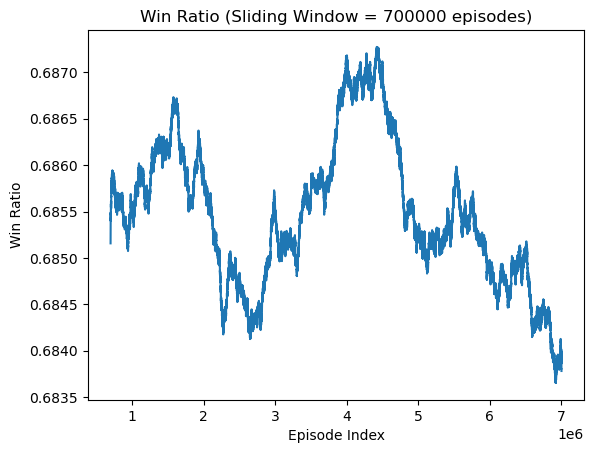

In [316]:
win_ratio = win_rows.rolling(window=window_size).mean()

plt.figure()
plt.plot(win_ratio)
plt.title(f"Win Ratio (Sliding Window = {window_size} episodes)")
plt.xlabel("Episode Index")
plt.ylabel("Win Ratio")
plt.show()

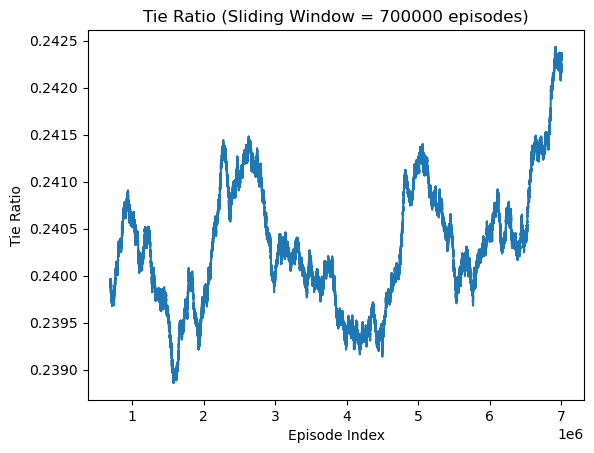

In [317]:
tie_ratio = tie_rows.rolling(window=window_size).mean()

plt.figure()
plt.plot(tie_ratio)
plt.title(f"Tie Ratio (Sliding Window = {window_size} episodes)")
plt.xlabel("Episode Index")
plt.ylabel("Tie Ratio")
plt.show()


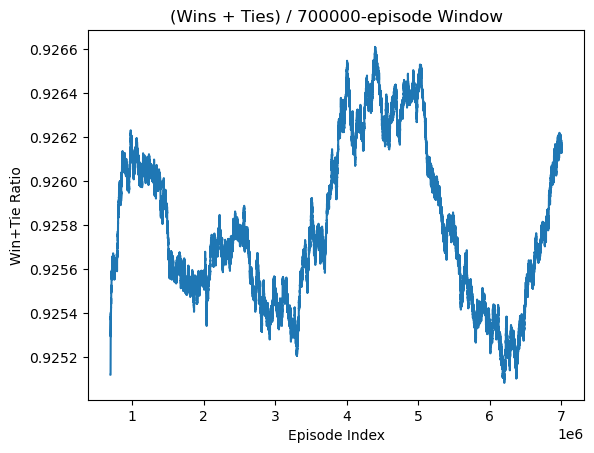

In [318]:
win_or_tie = win_rows | tie_rows

# Sliding “win+tie” ratio
win_tie_ratio = win_or_tie.rolling(window=window_size).mean()

# Plot it
import matplotlib.pyplot as plt

plt.figure()
plt.plot(win_tie_ratio)
plt.title(f"(Wins + Ties) / {window_size}-episode Window")
plt.xlabel("Episode Index")
plt.ylabel("Win+Tie Ratio")
plt.show()

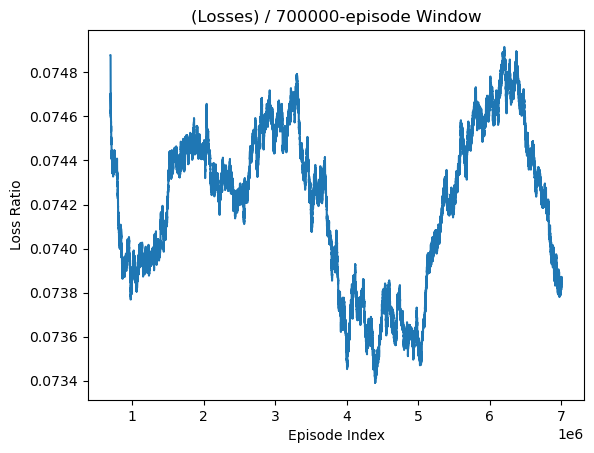

In [319]:
# Sliding “loss” ratio
loss_ratio = loss_rows.rolling(window=window_size).mean()

# Plot it
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_ratio)
plt.title(f"(Losses) / {window_size}-episode Window")
plt.xlabel("Episode Index")
plt.ylabel("Loss Ratio")
plt.show()

In [320]:
episodes["final_reward"].value_counts(normalize=True)

final_reward
 1.0    0.685359
-0.0    0.240393
-1.0    0.074248
Name: proportion, dtype: float64

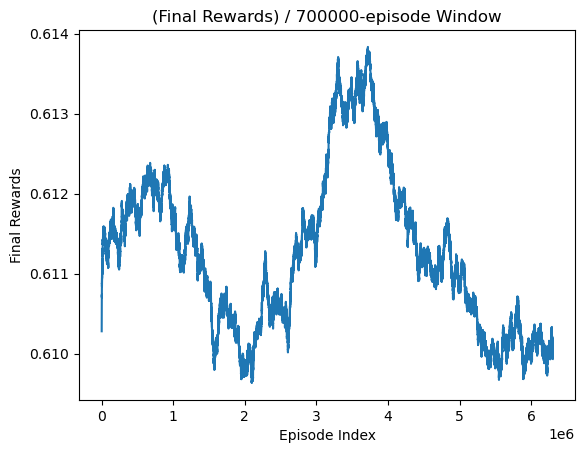

In [321]:
plt.figure()
plt.plot(get_moving_window_average(episodes["final_reward"], window_size=window_size))
plt.title(f"(Final Rewards) / {window_size}-episode Window")
plt.xlabel("Episode Index")
plt.ylabel("Final Rewards")
plt.show()

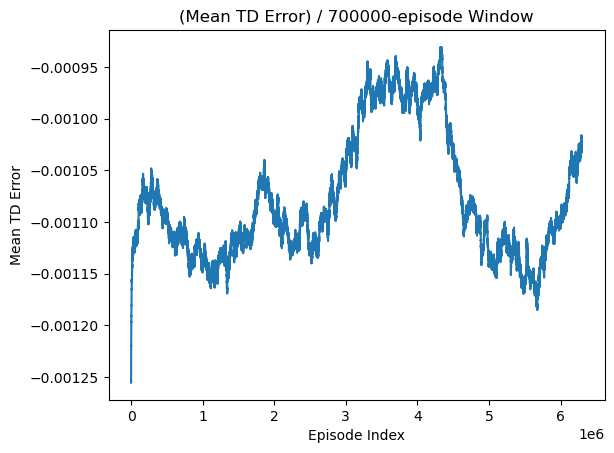

In [322]:
plt.figure()
plt.plot(get_moving_window_average(episodes["mean_td_error"], window_size=window_size))
plt.title(f"(Mean TD Error) / {window_size}-episode Window")
plt.xlabel("Episode Index")
plt.ylabel("Mean TD Error")
plt.show()

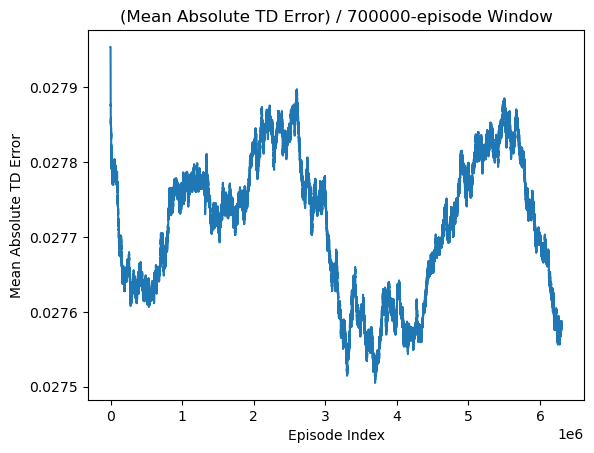

In [323]:
plt.figure()
plt.plot(get_moving_window_average(episodes["mean_abs_td_error"], window_size=window_size))
plt.title(f"(Mean Absolute TD Error) / {window_size}-episode Window")
plt.xlabel("Episode Index")
plt.ylabel("Mean Absolute TD Error")
plt.show()

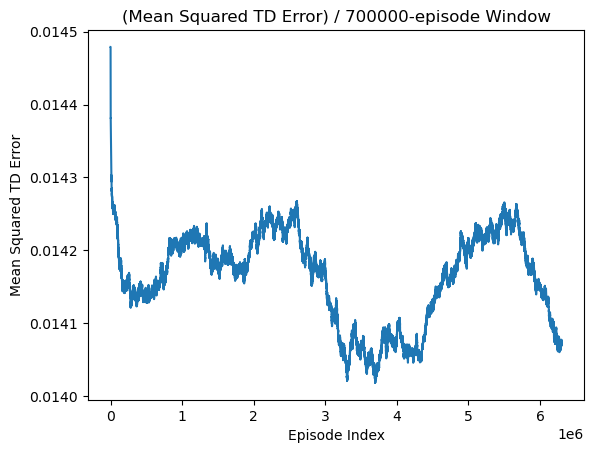

In [324]:
plt.figure()
plt.plot(get_moving_window_average(episodes["mean_squared_td_error"], window_size=window_size))
plt.title(f"(Mean Squared TD Error) / {window_size}-episode Window")
plt.xlabel("Episode Index")
plt.ylabel("Mean Squared TD Error")
plt.show()

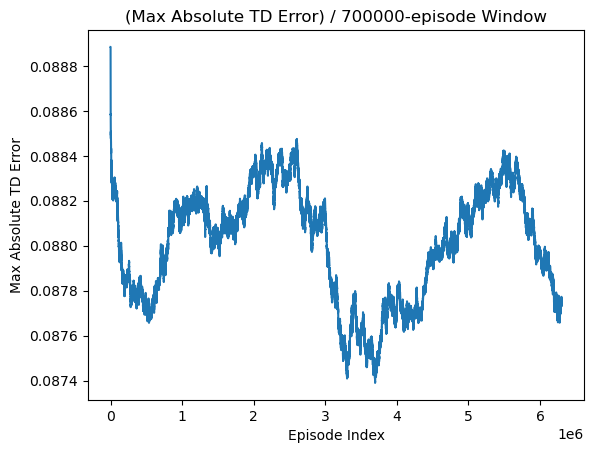

In [325]:
plt.figure()
plt.plot(get_moving_window_average(episodes["max_abs_td_error"], window_size=window_size))
plt.title(f"(Max Absolute TD Error) / {window_size}-episode Window")
plt.xlabel("Episode Index")
plt.ylabel("Max Absolute TD Error")
plt.show()